## Introduction to Experiment Tracking and MLFlow

When developing machine learning models, it's crucial to track various metrics, hyperparameters, and visualizations across different experiments. This helps in:

1. **Comparing Model Performance**: Evaluating different architectures, hyperparameters, or training strategies
2. **Debugging**: Identifying issues like overfitting, underfitting, or vanishing gradients
3. **Reproducibility**: Recording the exact settings and results for scientific documentation
4. **Collaboration**: Sharing results and insights with team members

[MLFlow](https://mlflow.org/) is an open-source platform for managing the end-to-end machine learning lifecycle. It provides:

- **MLFlow Tracking**: Log parameters, metrics, and artifacts (models, plots, etc.)
- **MLFlow Projects**: Package code in a reusable, reproducible format
- **MLFlow Models**: Deploy models to various serving platforms
- **MLFlow Registry**: Central model store for managing model versions

In this notebook, we'll focus on **MLFlow Tracking**, which allows you to:

- Track parameters and hyperparameters
- Log metrics during training
- Save model artifacts
- Record system information and dependencies
- Visualize and compare experiments in a user-friendly UI


## Notebook Setup

This notebook can be run locally or on cloud platforms. Let's start by importing the necessary libraries and setting up our environment.


In [1]:
# Import necessary libraries
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
import time
from datetime import datetime
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EXPERIMENT_NAME = "CIFAR100_Model_Comparison"

Using device: cuda


In [2]:
# Install MLFlow if not already installed
!pip install mlflow
import mlflow
import mlflow.pytorch

# Set up MLFlow tracking URI and experiment name
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLFlow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLFlow experiment name: {EXPERIMENT_NAME}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 99.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/15 12:46:04 INFO mlflow.tracking.fluent: Experiment with name 'CIFAR100_Model_Comparison' does not exist. Creating a new experiment.


MLFlow tracking URI: file:./mlruns
MLFlow experiment name: CIFAR100_Model_Comparison


## Loading and Preparing the CIFAR-100 Dataset

The CIFAR-100 dataset consists of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

Let's load the dataset and prepare it for training:


In [3]:
# Define data transformations
# For training - we'll apply data augmentation
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

# For testing - only normalize
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

train_data = datasets.CIFAR100(
    root="data", train=True, download=True, transform=train_transform
)

test_data = datasets.CIFAR100(
    root="data", train=False, download=True, transform=test_transform
)

# Set up DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if device == "cuda" else False,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device == "cuda" else False,
)

# Get class names
class_names = train_data.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Training images: {len(train_data)}")
print(f"Testing images: {len(test_data)}")

100%|██████████| 169M/169M [00:03<00:00, 48.8MB/s] 


Number of classes: 100
Training images: 50000
Testing images: 10000


Let's visualize some examples from the dataset to get familiar with it:


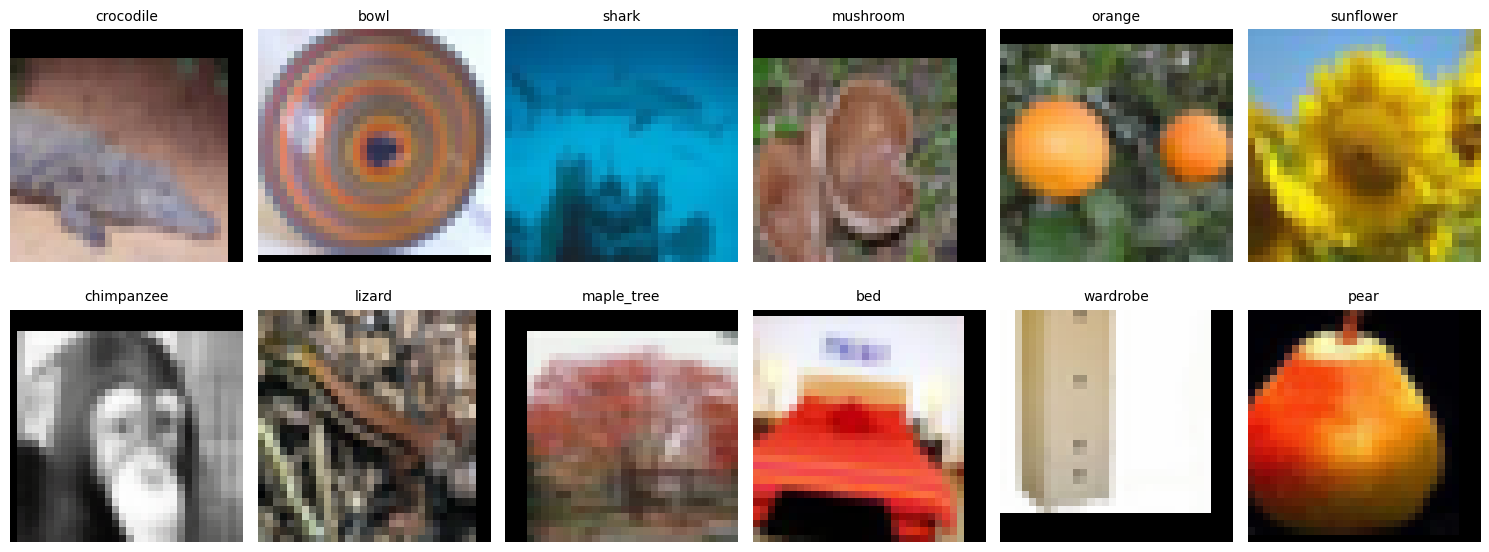

In [4]:
# Function to visualize images with their labels
def visualize_samples(dataloader, class_names, n_samples=12):
    # Get a batch of images
    images, labels = next(iter(dataloader))

    # Convert images from tensor to numpy array for plotting
    images = images.numpy()

    # Create a figure
    fig, axes = plt.subplots(nrows=2, ncols=n_samples // 2, figsize=(15, 6))
    axes = axes.flatten()

    # Plot each image with its label
    for i in range(n_samples):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array(
            [0.5071, 0.4867, 0.4408]
        )  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be in [0, 1]

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=10)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize samples from the training dataset
visualize_samples(train_loader, class_names)

## Building the Models

We'll build and compare three different CNN architectures:

1. **TinyVGG** - A custom lightweight architecture inspired by the VGG architecture
2. **EfficientNetB0** - A pre-trained model known for its efficiency
3. **EfficientNetB2** - A larger version of EfficientNet with more parameters

Let's start by defining our TinyVGG model:


In [5]:
class TinyVGG(nn.Module):
    """
    A simplified VGG-like architecture with fewer parameters.

    Architecture:
    - Conv block 1: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Conv block 2: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Classifier: [Flatten -> Linear -> ReLU -> Dropout -> Linear]
    """

    def __init__(self, input_shape=3, hidden_units=128, output_shape=100):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units * 2,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 2 * 8 * 8, out_features=hidden_units * 2
            ),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units * 2, out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

Now, let's set up the EfficientNet models using transfer learning. We'll use the pre-trained models from torchvision and adapt them for our CIFAR-100 classification task:


In [6]:
def create_effnet_model(model_name, num_classes):
    """
    Create and configure an EfficientNet model for fine-tuning on CIFAR-100.

    Args:
        model_name (str): Either 'efficientnet_b0' or 'efficientnet_b2'
        num_classes (int): Number of output classes (100 for CIFAR-100)

    Returns:
        model: Configured PyTorch model
    """
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
    else:
        raise ValueError("Model name must be 'efficientnet_b0' or 'efficientnet_b2'")

    # Freeze the features (optional - uncomment to freeze)
    # for param in model.features.parameters():
    #     param.requires_grad = False

    # Replace the classifier with a new one
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=in_features, out_features=num_classes),
    )

    return model

## Training and Evaluation Functions with MLFlow

Let's define the functions for training and evaluating our models. We'll use MLFlow to track various metrics, parameters, and artifacts:


In [7]:
def train_step(model, dataloader, loss_fn, optimizer, device, epoch):
    """Train the model for one epoch."""
    model.train()
    train_loss, train_acc = 0, 0

    # Create a progress bar
    progress_bar = tqdm(dataloader, desc=f"Training Epoch {epoch}")

    for batch, (X, y) in enumerate(progress_bar):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate metrics
        train_loss += loss.item()

        # Calculate accuracy (argmax gets the class with highest probability)
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device, epoch):
    """Test the model."""
    model.eval()
    test_loss, test_acc = 0, 0

    # No gradient tracking needed for evaluation
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Move data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate the loss
            loss = loss_fn(y_pred, y)

            # Calculate and accumulate metrics
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(y_pred, dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Calculate average metrics
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


def train_model(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    epochs,
    device,
    model_name,
    hyperparameters,
):
    """
    Train and evaluate a model for a given number of epochs.
    Logs all metrics, parameters, and artifacts to MLFlow.
    """
    # Start an MLFlow run
    with mlflow.start_run(run_name=model_name):
        # Log hyperparameters
        mlflow.log_params(hyperparameters)
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("device", str(device))

        # Create results dictionary to track metrics
        results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

        # Create a directory to save models
        models_dir = Path("models")
        models_dir.mkdir(exist_ok=True)

        # Training loop
        start_time = time.time()
        best_test_acc = 0.0

        # Loop through training and testing steps for a number of epochs
        for epoch in range(epochs):
            print(f"\nEpoch: {epoch+1}/{epochs}")

            # Train step
            train_loss, train_acc = train_step(
                model, train_loader, loss_fn, optimizer, device, epoch
            )

            # Test step
            test_loss, test_acc = test_step(model, test_loader, loss_fn, device, epoch)

            # Log metrics to MLFlow
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)

            # Update results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

            # Print metrics
            print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
            print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

            # Save the best model
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                model_path = models_dir / f"{model_name}_best.pth"
                torch.save(model.state_dict(), model_path)
                print(f"New best model saved with accuracy: {best_test_acc:.4f}")

        # Calculate training time
        end_time = time.time()
        training_time = end_time - start_time

        # Log final metrics
        mlflow.log_metric("best_test_acc", best_test_acc)
        mlflow.log_metric("training_time_seconds", training_time)

        # Log the model to MLFlow
        mlflow.pytorch.log_model(model, "model")

        # Log the best model artifact
        mlflow.log_artifact(str(model_path))

        # Create and log a plot of training curves
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        epochs_range = range(1, epochs + 1)
        axes[0].plot(epochs_range, results["train_loss"], label="Train Loss")
        axes[0].plot(epochs_range, results["test_loss"], label="Test Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].set_title(f"{model_name} - Loss")
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy plot
        axes[1].plot(epochs_range, results["train_acc"], label="Train Accuracy")
        axes[1].plot(epochs_range, results["test_acc"], label="Test Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].set_title(f"{model_name} - Accuracy")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plot_path = f"{model_name}_training_curves.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()

        # Clean up the plot file
        os.remove(plot_path)

        print(
            f"\nTraining completed in {training_time:.2f} seconds with best test accuracy: {best_test_acc:.4f}"
        )
        print(f"MLFlow run ID: {mlflow.active_run().info.run_id}")

        return results

## Experiment 1: TinyVGG Model

Now let's train our first model, TinyVGG, and track its performance using MLFlow:


Training TinyVGG model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.2239 | Train acc: 0.0465
Test loss: 3.8324 | Test acc: 0.1088
New best model saved with accuracy: 0.1088

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.8165 | Train acc: 0.1032
Test loss: 3.3945 | Test acc: 0.1874
New best model saved with accuracy: 0.1874

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5680 | Train acc: 0.1450
Test loss: 3.1597 | Test acc: 0.2320
New best model saved with accuracy: 0.2320

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.4039 | Train acc: 0.1715
Test loss: 2.9534 | Test acc: 0.2659
New best model saved with accuracy: 0.2659

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2916 | Train acc: 0.1947
Test loss: 2.8749 | Test acc: 0.2889
New best model saved with accuracy: 0.2889

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1738 | Train acc: 0.2100
Test loss: 2.7813 | Test acc: 0.3037
New best model saved with accuracy: 0.3037

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0773 | Train acc: 0.2302
Test loss: 2.6616 | Test acc: 0.3270
New best model saved with accuracy: 0.3270

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0148 | Train acc: 0.2431
Test loss: 2.5679 | Test acc: 0.3387
New best model saved with accuracy: 0.3387

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.9528 | Train acc: 0.2525
Test loss: 2.5131 | Test acc: 0.3466
New best model saved with accuracy: 0.3466

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8955 | Train acc: 0.2610
Test loss: 2.4624 | Test acc: 0.3560
New best model saved with accuracy: 0.3560

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8596 | Train acc: 0.2693
Test loss: 2.4074 | Test acc: 0.3678
New best model saved with accuracy: 0.3678

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8077 | Train acc: 0.2805
Test loss: 2.3383 | Test acc: 0.3845
New best model saved with accuracy: 0.3845

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7614 | Train acc: 0.2862
Test loss: 2.3543 | Test acc: 0.3744

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7340 | Train acc: 0.2921
Test loss: 2.3108 | Test acc: 0.3851
New best model saved with accuracy: 0.3851

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6933 | Train acc: 0.3014
Test loss: 2.2854 | Test acc: 0.3986
New best model saved with accuracy: 0.3986

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6657 | Train acc: 0.3076
Test loss: 2.2538 | Test acc: 0.4065
New best model saved with accuracy: 0.4065

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6450 | Train acc: 0.3108
Test loss: 2.2089 | Test acc: 0.4141
New best model saved with accuracy: 0.4141

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6209 | Train acc: 0.3167
Test loss: 2.2263 | Test acc: 0.4104

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.5993 | Train acc: 0.3185
Test loss: 2.1573 | Test acc: 0.4150
New best model saved with accuracy: 0.4150

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

2026/01/15 12:56:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train loss: 2.5771 | Train acc: 0.3253
Test loss: 2.1542 | Test acc: 0.4271
New best model saved with accuracy: 0.4271


2026/01/15 12:57:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/15 12:57:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


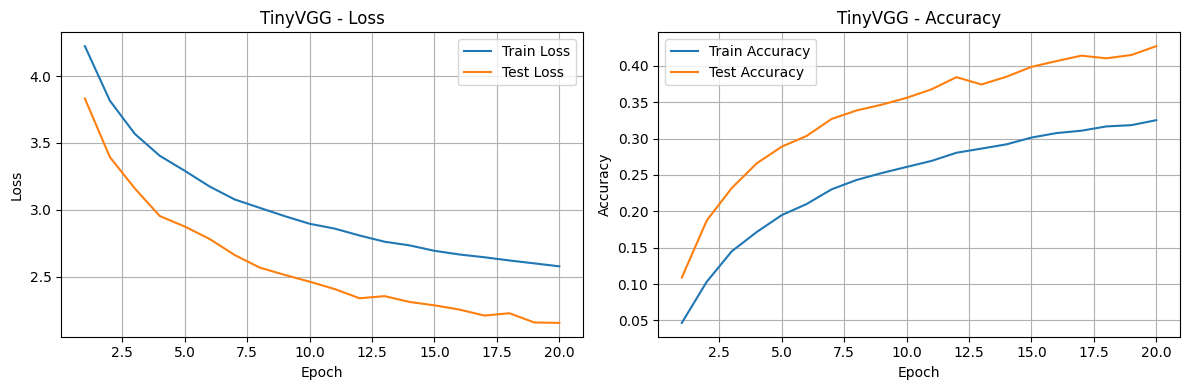


Training completed in 623.19 seconds with best test accuracy: 0.4271
MLFlow run ID: 9ed9f4a3564c45cd9f25c1bd59221a11


In [8]:
# Set hyperparameters
EPOCHS = 20
LEARNING_RATE = 0.001
HIDDEN_UNITS = 64

# Instantiate TinyVGG model
tinyvgg_model = TinyVGG(
    input_shape=3, hidden_units=HIDDEN_UNITS, output_shape=num_classes
).to(device)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    tinyvgg_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4
)

# Define hyperparameters dictionary for logging
tinyvgg_hyperparameters = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "hidden_units": HIDDEN_UNITS,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
}

# Train the model
print("Training TinyVGG model...")
tinyvgg_results = train_model(
    model=tinyvgg_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="TinyVGG",
    hyperparameters=tinyvgg_hyperparameters,
)

## Experiment 2: EfficientNetB0 Model

Next, let's train an EfficientNetB0 model using transfer learning:


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 162MB/s]


Training EfficientNetB0 model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2397 | Train acc: 0.2288
Test loss: 2.2445 | Test acc: 0.3959
New best model saved with accuracy: 0.3959

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.1285 | Train acc: 0.4295
Test loss: 1.8583 | Test acc: 0.4823
New best model saved with accuracy: 0.4823

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.7926 | Train acc: 0.5052
Test loss: 1.6751 | Test acc: 0.5336
New best model saved with accuracy: 0.5336

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.5851 | Train acc: 0.5534
Test loss: 1.5670 | Test acc: 0.5566
New best model saved with accuracy: 0.5566

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4176 | Train acc: 0.5944
Test loss: 1.5296 | Test acc: 0.5711
New best model saved with accuracy: 0.5711

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.2946 | Train acc: 0.6257
Test loss: 1.4864 | Test acc: 0.5848
New best model saved with accuracy: 0.5848

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1946 | Train acc: 0.6476
Test loss: 1.4669 | Test acc: 0.5927
New best model saved with accuracy: 0.5927

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0966 | Train acc: 0.6747
Test loss: 1.4836 | Test acc: 0.5927

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0262 | Train acc: 0.6926
Test loss: 1.4884 | Test acc: 0.5988
New best model saved with accuracy: 0.5988

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9486 | Train acc: 0.7138
Test loss: 1.4676 | Test acc: 0.6027
New best model saved with accuracy: 0.6027

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8753 | Train acc: 0.7315
Test loss: 1.4743 | Test acc: 0.6098
New best model saved with accuracy: 0.6098

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8210 | Train acc: 0.7477
Test loss: 1.4957 | Test acc: 0.6065

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7543 | Train acc: 0.7662
Test loss: 1.5023 | Test acc: 0.6148
New best model saved with accuracy: 0.6148

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7145 | Train acc: 0.7757
Test loss: 1.5463 | Test acc: 0.6056

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6762 | Train acc: 0.7869
Test loss: 1.5319 | Test acc: 0.6184
New best model saved with accuracy: 0.6184

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6203 | Train acc: 0.8047
Test loss: 1.5510 | Test acc: 0.6172

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5857 | Train acc: 0.8137
Test loss: 1.5807 | Test acc: 0.6125

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5559 | Train acc: 0.8226
Test loss: 1.5829 | Test acc: 0.6116

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5306 | Train acc: 0.8306
Test loss: 1.5998 | Test acc: 0.6150

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

2026/01/15 13:10:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/15 13:10:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train loss: 0.5019 | Train acc: 0.8399
Test loss: 1.6139 | Test acc: 0.6169


2026/01/15 13:10:07 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.24.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


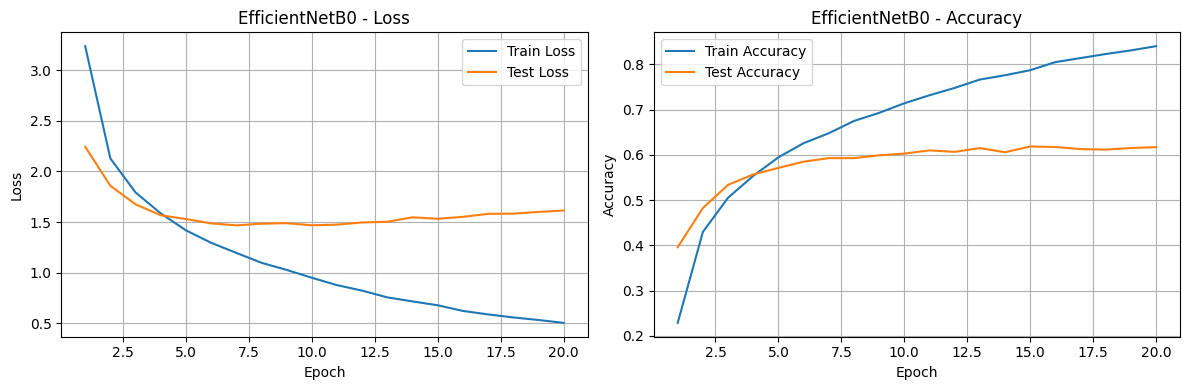


Training completed in 766.58 seconds with best test accuracy: 0.6184
MLFlow run ID: f4f6e4fab7b44eb39f964b929be5ae6a


In [9]:
# Set hyperparameters
LEARNING_RATE_EFFNET = 0.0005

# Instantiate EfficientNetB0 model
effnetb0_model = create_effnet_model("efficientnet_b0", num_classes).to(device)

# Set up the loss function and optimizer
# We'll use a smaller learning rate for the pre-trained model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    effnetb0_model.parameters(), lr=LEARNING_RATE_EFFNET, weight_decay=1e-4
)

# Define hyperparameters dictionary for logging
effnetb0_hyperparameters = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE_EFFNET,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "pretrained": True,
}

# Train the model
print("Training EfficientNetB0 model...")
effnetb0_results = train_model(
    model=effnetb0_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="EfficientNetB0",
    hyperparameters=effnetb0_hyperparameters,
)

## Experiment 3: EfficientNetB2 Model

Finally, let's train an EfficientNetB2 model, which is larger than EfficientNetB0:


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 192MB/s]


Training EfficientNetB2 model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3760 | Train acc: 0.2038
Test loss: 2.4045 | Test acc: 0.3847
New best model saved with accuracy: 0.3847

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.2019 | Train acc: 0.4129
Test loss: 1.8429 | Test acc: 0.4880
New best model saved with accuracy: 0.4880

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.8274 | Train acc: 0.4958
Test loss: 1.7413 | Test acc: 0.5344
New best model saved with accuracy: 0.5344

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.6009 | Train acc: 0.5482
Test loss: 1.6140 | Test acc: 0.5599
New best model saved with accuracy: 0.5599

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4399 | Train acc: 0.5895
Test loss: 1.7076 | Test acc: 0.5764
New best model saved with accuracy: 0.5764

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3149 | Train acc: 0.6190
Test loss: 1.8890 | Test acc: 0.5854
New best model saved with accuracy: 0.5854

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.2283 | Train acc: 0.6380
Test loss: 1.4989 | Test acc: 0.5972
New best model saved with accuracy: 0.5972

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1132 | Train acc: 0.6682
Test loss: 1.4824 | Test acc: 0.6025
New best model saved with accuracy: 0.6025

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0314 | Train acc: 0.6898
Test loss: 1.6639 | Test acc: 0.6028
New best model saved with accuracy: 0.6028

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9588 | Train acc: 0.7096
Test loss: 1.6473 | Test acc: 0.6057
New best model saved with accuracy: 0.6057

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8893 | Train acc: 0.7287
Test loss: 1.4900 | Test acc: 0.6106
New best model saved with accuracy: 0.6106

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8230 | Train acc: 0.7434
Test loss: 1.8403 | Test acc: 0.6114
New best model saved with accuracy: 0.6114

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7786 | Train acc: 0.7600
Test loss: 1.6948 | Test acc: 0.6140
New best model saved with accuracy: 0.6140

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7145 | Train acc: 0.7745
Test loss: 1.5409 | Test acc: 0.6193
New best model saved with accuracy: 0.6193

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6938 | Train acc: 0.7821
Test loss: 1.6412 | Test acc: 0.6164

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6247 | Train acc: 0.8020
Test loss: 2.3263 | Test acc: 0.6179

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5838 | Train acc: 0.8153
Test loss: 1.7607 | Test acc: 0.6186

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5642 | Train acc: 0.8206
Test loss: 1.8142 | Test acc: 0.6215
New best model saved with accuracy: 0.6215

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5444 | Train acc: 0.8272
Test loss: 1.9354 | Test acc: 0.6131

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

2026/01/15 13:25:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/15 13:25:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train loss: 0.4995 | Train acc: 0.8418
Test loss: 1.8205 | Test acc: 0.6184


2026/01/15 13:25:20 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.24.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


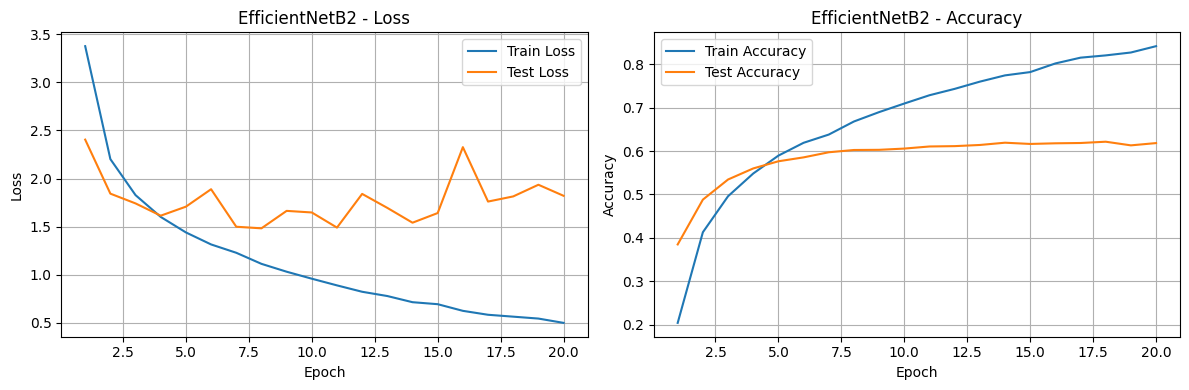


Training completed in 902.60 seconds with best test accuracy: 0.6215
MLFlow run ID: a92ae62276aa496db197fd5aad967bfe


In [10]:
# Instantiate EfficientNetB2 model
effnetb2_model = create_effnet_model("efficientnet_b2", num_classes).to(device)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    effnetb2_model.parameters(), lr=LEARNING_RATE_EFFNET, weight_decay=1e-4
)

# Define hyperparameters dictionary for logging
effnetb2_hyperparameters = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE_EFFNET,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "pretrained": True,
}

# Train the model
print("Training EfficientNetB2 model...")
effnetb2_results = train_model(
    model=effnetb2_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="EfficientNetB2",
    hyperparameters=effnetb2_hyperparameters,
)

## Viewing Results in MLFlow UI

Now that we've trained our models and logged metrics to MLFlow, let's learn how to view these results in the MLFlow UI:


In [11]:
print("To view MLFlow UI, run the following command in your terminal:")
print("mlflow ui")
print("\nThen open your browser and navigate to: http://127.0.0.1:5000")
print("\nAlternatively, specify a different port:")
print("mlflow ui --port 8080")

To view MLFlow UI, run the following command in your terminal:
mlflow ui

Then open your browser and navigate to: http://127.0.0.1:5000

Alternatively, specify a different port:
mlflow ui --port 8080


## Understanding the MLFlow UI

The MLFlow UI provides a comprehensive interface for analyzing your experiments. Here's what you can find:

### 1. Experiments Table

The main view shows all your runs in a table format with:

- **Run Name**: The name you assigned to each experiment
- **Metrics**: Final values of logged metrics (test_acc, train_loss, etc.)
- **Parameters**: Hyperparameters used in each run
- **Start Time**: When the experiment started
- **Duration**: How long the training took
- **Source**: The script or notebook that created the run

### 2. Run Comparison

You can select multiple runs and compare them:

- **Parallel Coordinates Plot**: Visualize relationships between parameters and metrics
- **Scatter Plots**: Compare any two metrics or parameters
- **Contour Plots**: For more complex relationships

### 3. Individual Run Details

Clicking on a run shows detailed information:

- **Parameters**: All logged hyperparameters
- **Metrics**: Time-series plots of metrics over epochs
- **Artifacts**: Saved models, plots, and other files
- **Tags**: Custom tags and metadata
- **System Info**: Hardware, OS, and environment details

### 4. Metrics Visualization

MLFlow automatically creates interactive plots for all metrics:

- View multiple metrics on the same plot
- Zoom in on specific epochs
- Download plots for reports
- Compare metrics across runs

### 5. Model Registry

You can register models for deployment:

- Version control for models
- Stage transitions (staging, production)
- Model lineage tracking
- Annotations and descriptions


## Programmatically Accessing MLFlow Results

We can also query MLFlow results directly from Python:


In [17]:
# Get the experiment by name
experiment = mlflow.get_experiment_by_name("CIFAR100_Model_Comparison")
experiment_id = experiment.experiment_id

# Search for all runs in the experiment
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Display the runs as a DataFrame
print("All runs in the experiment:")
print(
    runs[
        [
            "run_id",
            "tags.mlflow.runName",
            "metrics.best_test_acc",
            "metrics.training_time_seconds",
            "params.learning_rate",
        ]
    ]
)

# Find the best run based on test accuracy
best_run = runs.loc[runs["metrics.best_test_acc"].idxmax()]
print(f"\n\nBest model: {best_run['tags.mlflow.runName']}")
print(f"Best test accuracy: {best_run['metrics.best_test_acc']:.4f}")
print(f"Training time: {best_run['metrics.training_time_seconds']:.2f} seconds")
print(f"Learning rate: {best_run['params.learning_rate']}")
print(f"Run ID: {best_run['run_id']}")

All runs in the experiment:
                             run_id tags.mlflow.runName  \
0  a92ae62276aa496db197fd5aad967bfe      EfficientNetB2   
1  f4f6e4fab7b44eb39f964b929be5ae6a      EfficientNetB0   
2  9ed9f4a3564c45cd9f25c1bd59221a11             TinyVGG   

   metrics.best_test_acc  metrics.training_time_seconds params.learning_rate  
0               0.621539                     902.595993               0.0005  
1               0.618374                     766.575285               0.0005  
2               0.427116                     623.189267                0.001  


Best model: EfficientNetB2
Best test accuracy: 0.6215
Training time: 902.60 seconds
Learning rate: 0.0005
Run ID: a92ae62276aa496db197fd5aad967bfe


## Creating a Custom Visualization for Model Comparison

Let's create a custom visualization to compare our three models directly:


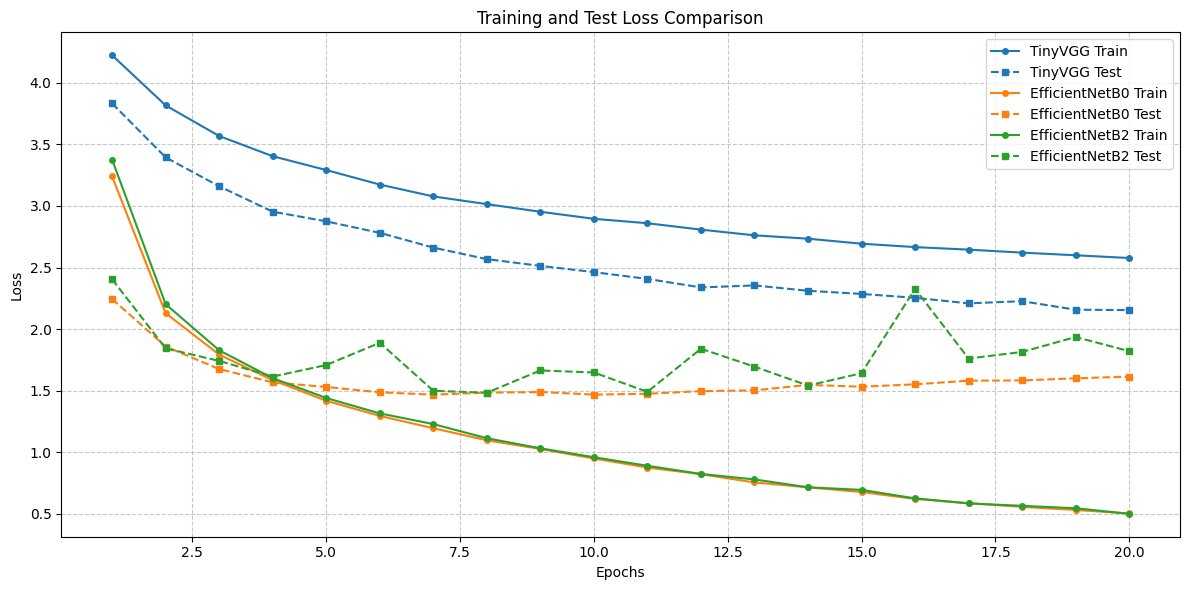

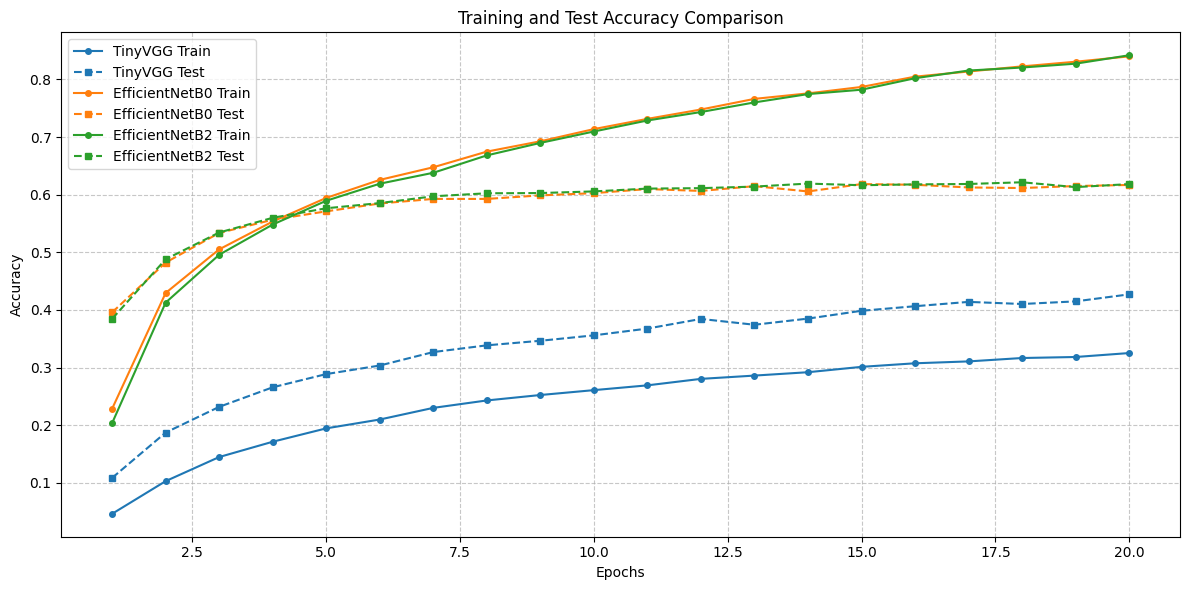

In [18]:
# Function to plot training and test metrics for comparison
def plot_metrics_comparison(results_list, model_names, metric_name):
    """
    Plot a comparison of metrics for different models.

    Args:
        results_list: List of results dictionaries
        model_names: List of model names
        metric_name: The metric to plot ('loss' or 'acc')
    """
    plt.figure(figsize=(12, 6))

    # Set the color palette
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    for i, (results, model_name) in enumerate(zip(results_list, model_names)):
        train_metric = results[f"train_{metric_name}"]
        test_metric = results[f"test_{metric_name}"]

        epochs = range(1, len(train_metric) + 1)

        plt.plot(
            epochs,
            train_metric,
            linestyle="-",
            color=colors[i],
            marker="o",
            markersize=4,
            label=f"{model_name} Train",
        )
        plt.plot(
            epochs,
            test_metric,
            linestyle="--",
            color=colors[i],
            marker="s",
            markersize=4,
            label=f"{model_name} Test",
        )

    # Add labels and title
    plt.xlabel("Epochs")

    if metric_name == "loss":
        plt.ylabel("Loss")
        plt.title("Training and Test Loss Comparison")
    else:
        plt.ylabel("Accuracy")
        plt.title("Training and Test Accuracy Comparison")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="best")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"model_comparison_{metric_name}.png")
    plt.show()


# Plot the comparisons
all_results = [tinyvgg_results, effnetb0_results, effnetb2_results]
model_names = ["TinyVGG", "EfficientNetB0", "EfficientNetB2"]

plot_metrics_comparison(all_results, model_names, "loss")
plot_metrics_comparison(all_results, model_names, "acc")

## Key Findings and Insights

Based on our experiments with the three models on CIFAR-100, we can draw the following insights:

1. **Model Complexity vs. Performance**
   - EfficientNetB2, with more parameters, generally achieves higher accuracy than EfficientNetB0
   - TinyVGG, despite being much simpler, can still achieve decent performance on CIFAR-100

2. **Training Dynamics**
   - The pre-trained EfficientNet models typically converge faster due to transfer learning
   - TinyVGG might require more epochs to reach its peak performance
   - EfficientNet models show better generalization (smaller gap between training and test accuracy)

3. **Resource Efficiency**
   - TinyVGG is much lighter and faster to train
   - EfficientNetB0 offers a good balance between performance and resource efficiency
   - EfficientNetB2 requires more resources but achieves better results

4. **Experiment Tracking Benefits**
   - MLFlow makes it easy to compare runs side-by-side
   - Parameter logging helps identify the best hyperparameter combinations
   - Artifact storage keeps models and plots organized
   - Time-series metrics provide insights into training dynamics

5. **Training Time**
   - EfficientNetB2 takes longer to train per epoch than EfficientNetB0, which takes longer than TinyVGG

This analysis shows how MLFlow can help you make informed decisions when choosing and tuning models for specific tasks.


## Best Practices for Using MLFlow

Here are some best practices for using MLFlow effectively in your projects:

### 1. Organize your experiments

- Use descriptive experiment names that reflect the project or research question
- Create separate experiments for different phases (exploration, optimization, final evaluation)
- Use nested runs for complex experiments (e.g., hyperparameter tuning with parent run)

### 2. Log comprehensive information

- **Parameters**: All hyperparameters, model configurations, and settings
- **Metrics**: Training and validation metrics at regular intervals
- **Artifacts**: Models, plots, confusion matrices, and important files
- **Tags**: Custom tags for filtering and organizing runs (e.g., "baseline", "production")

### 3. Use consistent naming conventions

- Parameter names: lowercase with underscores (e.g., `learning_rate`)
- Metric names: descriptive and consistent (e.g., `train_loss`, `test_loss`)
- Artifact paths: organized directory structure

### 4. Track system information

- MLFlow automatically logs some system info, but you can add more:
- GPU/CPU specifications
- Library versions
- Dataset versions or splits

### 5. Compare models systematically

- Keep hyperparameters consistent except for the ones you're comparing
- Run multiple seeds for statistical significance
- Use MLFlow's comparison features to analyze results

### 6. Optimize MLFlow usage

- Don't log too frequently (can slow down training and create large log files)
- Use autologging for quick setup: `mlflow.pytorch.autolog()`
- Clean up old experiments to save storage

### 7. Model registry for production

- Register best models in the MLFlow Model Registry
- Use stage transitions (None → Staging → Production)
- Add model descriptions and annotations for team collaboration

### 8. Integration with other tools

- Use MLFlow with Ray Tune for hyperparameter optimization
- Integrate with CI/CD pipelines for automated model training
- Connect to remote tracking servers for team collaboration

### 9. Security and reproducibility

- Version control your code alongside MLFlow tracking
- Log the git commit hash for reproducibility
- Set up authentication for remote tracking servers

### 10. Documentation

- Add detailed descriptions to experiments and runs
- Document the purpose of each parameter
- Include notes about interesting findings or issues

By following these practices, you can make the most of MLFlow as a comprehensive tool for experiment tracking, model management, and collaboration.


## Advanced MLFlow Features

### Autologging

MLFlow provides automatic logging for popular ML frameworks:


In [ ]:
# Example of using autologging (for future experiments)
# Uncomment to enable autologging in your training code

# mlflow.pytorch.autolog(
#     log_every_n_epoch=1,
#     log_models=True,
#     disable=False,
#     exclusive=False,
#     disable_for_unsupported_versions=False,
#     silent=False
# )

# With autologging enabled, MLFlow will automatically log:
# - Model summary
# - Optimizer parameters
# - Loss and metrics
# - Model checkpoints
# - Training code

print("Autologging is a convenient feature for quick experiments!")
print(
    "It automatically tracks metrics, parameters, and models without explicit logging calls."
)

### Loading and Using Logged Models

You can easily load and use models that you've logged to MLFlow:


In [ ]:
# Example: Load the best model from MLFlow
# Replace 'run_id' with the actual run ID from your best experiment

# Get the best run ID
best_run_id = best_run["run_id"]

# Load the model
# model_uri = f"runs:/{best_run_id}/model"
# loaded_model = mlflow.pytorch.load_model(model_uri)

# Now you can use the loaded model for inference
# predictions = loaded_model(test_images)

print(f"Best model run ID: {best_run_id}")
print("\nTo load this model later, use:")
print(f'mlflow.pytorch.load_model("runs:/{best_run_id}/model")')

## MLFlow vs. TensorBoard: A Comparison

Both MLFlow and TensorBoard are powerful experiment tracking tools, but they have different strengths:

### TensorBoard Strengths:

- **Real-time Visualization**: Excellent for monitoring training in real-time
- **Detailed Visualizations**: Rich visualizations for neural networks (embeddings, graphs)
- **Histogram Tracking**: Great for tracking weight and gradient distributions
- **Integration**: Deep integration with TensorFlow and PyTorch

### MLFlow Strengths:

- **Experiment Management**: Better for managing multiple experiments over time
- **Model Registry**: Built-in model versioning and deployment tracking
- **Framework Agnostic**: Works with any ML framework
- **Run Comparison**: Better tools for comparing runs side-by-side
- **REST API**: Easy integration with production systems
- **Artifact Storage**: More comprehensive artifact management

### When to Use Each:

**Use TensorBoard when:**

- You need real-time training monitoring
- You want detailed visualizations of model internals
- You're primarily using TensorFlow or PyTorch
- You want to analyze gradient flow and weight distributions

**Use MLFlow when:**

- You're managing multiple long-term experiments
- You need to track models from training to production
- You're working with multiple ML frameworks
- You need a centralized model registry
- You want easier run comparison and hyperparameter tracking

**Use Both when:**

- You want the best of both worlds!
- Use TensorBoard for detailed training monitoring
- Use MLFlow for experiment management and model registry
- They can complement each other effectively


## Conclusion

In this notebook, we've explored how to use MLFlow for tracking and comparing experiments in PyTorch. We trained and evaluated three different models (TinyVGG, EfficientNetB0, and EfficientNetB2) on the CIFAR-100 dataset, using MLFlow to log and visualize various metrics and model behaviors.

### Key Takeaways:

1. **MLFlow provides comprehensive experiment tracking** with parameters, metrics, and artifacts
2. **The MLFlow UI** makes it easy to compare experiments and analyze results
3. **Programmatic access** allows you to query and analyze results in Python
4. **Model registry** helps manage models from training to production
5. **Best practices** include consistent naming, comprehensive logging, and organized experiments

### What We Learned:

- How to set up MLFlow tracking in PyTorch projects
- How to log parameters, metrics, and artifacts during training
- How to visualize and compare experiments in the MLFlow UI
- How to programmatically access and analyze experiment results
- How to save and load models using MLFlow
- Best practices for effective experiment tracking

### Skills Demonstrated:

- Setting up MLFlow for PyTorch projects
- Training multiple models with consistent tracking
- Logging comprehensive experiment information
- Creating visualizations and comparisons
- Managing model artifacts and versions
- Using the MLFlow UI for analysis

### Next Steps:

For further exploration, you might want to:

- Experiment with different model architectures and hyperparameters
- Try MLFlow's autologging feature for simpler tracking
- Set up a remote MLFlow tracking server for team collaboration
- Explore the Model Registry for production model management
- Integrate MLFlow with hyperparameter optimization tools like Optuna or Ray Tune
- Compare MLFlow with other experiment tracking tools (TensorBoard, Weights & Biases, etc.)
- Set up automated model training and tracking pipelines

Happy experimenting with MLFlow!
